<a href="https://colab.research.google.com/github/griu/deeplearningupc/blob/master/aidl2019_cv_lab5_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from matplotlib.pyplot import imshow
if not torch.cuda.is_available():
    print("You should enable GPU runtime!!")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline

# First contact with PyTorch

We will first train a network to classify MNIST to get familiarized with PyTorch's syntax.


First, we define our neural network. In PyTorch,  NN are just Python classes that inherit from nn.Module. We declare all the layers that we are going to use in the constructor (init method), and then define how we should do the forward pass in the `forward` method. The `backward` method is done automatically, so we do not need to code it.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=4*4*50, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)  # Flatten while keeping the batch dimension
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x
   

model = Net().to(device)  # Move model to GPU

We now define the dataloaders that will feed the data to our NN during trainig in batches. The `dataset` class `torchvision.dataset.MNIST` already has the MNIST dataset loaded. We could add data augmentation here.

In [4]:
train_dataset = datasets.MNIST("data/MNIST", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),  # Here we could add extra data augmentation
                       transforms.Normalize((0.1307,), (0.3081,)),
                   ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

test_dataset = datasets.MNIST("data/MNIST", train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                   ]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 8816902.48it/s]                            


Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129457.39it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2204996.39it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 47545.02it/s]            


Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


For our optimizer, we will use SGD, and it will optimize the parameters of our model. For our loss, we wil use Negative Log Likelihood (together with the log_softmax of the last layer it is equivalent to the Cross Entropy while being more numerically stable).

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.NLLLoss()

We will define a custom metric to monitor during training.

In [0]:
def accuracy(preds, y):
    preds = preds.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct = preds.eq(y.view_as(preds)).sum().item()
    return correct/preds.size(0)

Here, we do our training. At each step we do a forward pass of our input, we compute the gradients and we do an optimizer step. At the end of each epoch we also compute metrics with our validation dataset.

In [26]:
epochs = 10
for epoch in range(epochs):
    model.train()  # Train mode
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()  # Reset gradients from last step
        preds = model(x)  # Forward pass
        loss = criterion(preds, y)
        loss.backward()  # Compute gradients
        optimizer.step()  # Do an optimizer step
        if i%20 == 0:
            print(f"TRAIN Epoch {epoch}: [{i}/{len(train_loader)}] Loss: {loss.item():.4f}; Accuracy: {accuracy(preds, y)}")
        
    
    model.eval()  # Test mode
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        if i%20 == 0:
            print(f"TEST Epoch {epoch}: [{i}/{len(test_loader)}] Loss: {loss.item():.4f}; Accuracy: {accuracy(preds, y)}")

TRAIN Epoch 0: [0/500] Loss: 1.1183; Accuracy: 0.56
TRAIN Epoch 0: [20/500] Loss: 0.9881; Accuracy: 0.62
TRAIN Epoch 0: [40/500] Loss: 1.0352; Accuracy: 0.6
TRAIN Epoch 0: [60/500] Loss: 1.3214; Accuracy: 0.61
TRAIN Epoch 0: [80/500] Loss: 1.3655; Accuracy: 0.42
TRAIN Epoch 0: [100/500] Loss: 0.8846; Accuracy: 0.74
TRAIN Epoch 0: [120/500] Loss: 1.1711; Accuracy: 0.58
TRAIN Epoch 0: [140/500] Loss: 1.0779; Accuracy: 0.59
TRAIN Epoch 0: [160/500] Loss: 0.9318; Accuracy: 0.69
TRAIN Epoch 0: [180/500] Loss: 0.9817; Accuracy: 0.69
TRAIN Epoch 0: [200/500] Loss: 1.0939; Accuracy: 0.57
TRAIN Epoch 0: [220/500] Loss: 0.6934; Accuracy: 0.79
TRAIN Epoch 0: [240/500] Loss: 1.0464; Accuracy: 0.66
TRAIN Epoch 0: [260/500] Loss: 1.0419; Accuracy: 0.63
TRAIN Epoch 0: [280/500] Loss: 0.8602; Accuracy: 0.74
TRAIN Epoch 0: [300/500] Loss: 0.9258; Accuracy: 0.69
TRAIN Epoch 0: [320/500] Loss: 1.1176; Accuracy: 0.64
TRAIN Epoch 0: [340/500] Loss: 0.8646; Accuracy: 0.71
TRAIN Epoch 0: [360/500] Loss: 0.87

In [30]:
5*5*50

1250

In [0]:
##   32*32
##   32 - 4  = 28    # no padding kernel 5, stride 1
##   28 / 2  = 14    # no padding kernel 5, stride 1
##   14 - 4  = 10    # no padding kernel 5, stride 1
##   10 / 2  = 5     # no padding kernel 5, stride 1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=5*5*50, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)  # Flatten while keeping the batch dimension
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x


In [0]:
model = Net().to(device)

In [10]:
train_dataset = datasets.CIFAR10("data/CIFAR10", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),  # Here we could add extra data augmentation
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

test_dataset = datasets.CIFAR10("data/CIFAR10", train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)


0it [00:00, ?it/s]

100%|█████████▉| 169975808/170498071 [00:33<00:00, 9525922.24it/s]

Files already downloaded and verified


In [0]:
train_dataset

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.NLLLoss()



In [25]:
epochs = 3
for epoch in range(epochs):
    model.train()  # Train mode
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()  # Reset gradients from last step
        preds = model(x)  # Forward pass
        loss = criterion(preds, y)
        loss.backward()  # Compute gradients
        optimizer.step()  # Do an optimizer step
        if i%20 == 0:
            print(f"TRAIN Epoch {epoch}: [{i}/{len(train_loader)}] Loss: {loss.item():.4f}; Accuracy: {accuracy(preds, y)}")
        
    
    model.eval()  # Test mode
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        if i%20 == 0:
            print(f"TEST Epoch {epoch}: [{i}/{len(test_loader)}] Loss: {loss.item():.4f}; Accuracy: {accuracy(preds, y)}")

TRAIN Epoch 0: [0/500] Loss: 2.3007; Accuracy: 0.05
TRAIN Epoch 0: [20/500] Loss: 2.2784; Accuracy: 0.22
TRAIN Epoch 0: [40/500] Loss: 2.1207; Accuracy: 0.24
TRAIN Epoch 0: [60/500] Loss: 2.1040; Accuracy: 0.26
TRAIN Epoch 0: [80/500] Loss: 2.0382; Accuracy: 0.27
TRAIN Epoch 0: [100/500] Loss: 1.9729; Accuracy: 0.27
TRAIN Epoch 0: [120/500] Loss: 1.9218; Accuracy: 0.34
TRAIN Epoch 0: [140/500] Loss: 1.7837; Accuracy: 0.34
TRAIN Epoch 0: [160/500] Loss: 1.9058; Accuracy: 0.26
TRAIN Epoch 0: [180/500] Loss: 1.7861; Accuracy: 0.32
TRAIN Epoch 0: [200/500] Loss: 1.7969; Accuracy: 0.29
TRAIN Epoch 0: [220/500] Loss: 1.6589; Accuracy: 0.47
TRAIN Epoch 0: [240/500] Loss: 1.5434; Accuracy: 0.43
TRAIN Epoch 0: [260/500] Loss: 1.5481; Accuracy: 0.48
TRAIN Epoch 0: [280/500] Loss: 1.7799; Accuracy: 0.33
TRAIN Epoch 0: [300/500] Loss: 1.7060; Accuracy: 0.38
TRAIN Epoch 0: [320/500] Loss: 1.6001; Accuracy: 0.34
TRAIN Epoch 0: [340/500] Loss: 1.6437; Accuracy: 0.39
TRAIN Epoch 0: [360/500] Loss: 1.7

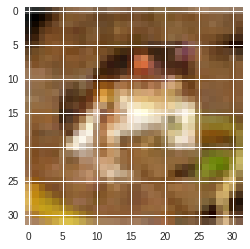

In [32]:
imshow(train_dataset.data[0])

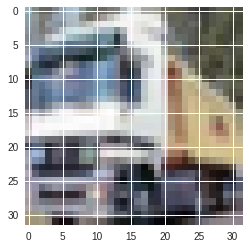

In [34]:
imshow(train_dataset.data[1])

## Exercice 1: train with CIFAR10

You should complete the following code to train a network with CIFAR10.

If you want, you can try to add data augmentation, dropout and weight decay to regularize the model.

# Pretrained imagenet models

In both PyTorch and Keras there are many models pretrained with Imagenet. You can see the lists here: https://pytorch.org/docs/stable/torchvision/models.html 
and https://keras.io/applications/.
We will see how to use a pretrained VGG16 from PyTorch to predict images taken from the internet.


We first declare our model with `pretrained=True`, which will download the pretrained weights.

In [42]:
import torchvision.models as models

model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth

0it [00:00, ?it/s]
3670016it [00:00, 35563745.81it/s]
9895936it [00:00, 40786933.25it/s]
15818752it [00:00, 44952362.34it/s]
19423232it [00:00, 39574036.63it/s]
26951680it [00:00, 46132878.27it/s]
31621120it [00:00, 44310315.85it/s]
36110336it [00:00, 34253147.69it/s]
41377792it [00:00, 38266475.05it/s]
48226304it [00:01, 44003687.91it/s]
53231616it [00:01, 33615139.19it/s]
57794560it [00:01, 36463293.21it/s]
64397312it [00:01, 42119998.09it/s]
71884800it [00:01, 48475923.96it/s]
77611008it [00:01, 48622726.54it/s]
83091456it [00:01, 41153534.82it/s]
89169920it [00:01, 45566467.79it/s]
94314496it [00:02, 42610023.22it/s]
100777984it [00:02, 45316766.01it/s]
108363776it [00:02, 51536885.34it/s]
114065408it [00:02, 51474038.48it/s]
119603200it [00:02, 47300947.57it/s]
124829696it [00:02, 48260188.96it/s]
129900544it [00:02, 48804521.67it/s]
137158656it [00:02, 5412

We also load the 1000 imagenet labels in a Python dictionary.

In [43]:
import json
import ast
import urllib
urllib.request.urlretrieve("https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt", "labels.json")
with open("labels.json") as f:
    labels = ast.literal_eval(f.read())
print(labels)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

We can now download a sample image to test our network.

data/  image.jpg  labels.json  sample_data/


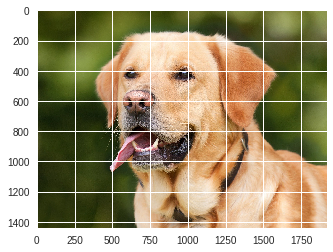

In [44]:
import urllib
from PIL import Image
urllib.request.urlretrieve("https://3c1703fe8d.site.internapcdn.net/newman/gfx/news/hires/2018/2-dog.jpg", "image.jpg")
%ls
pil_image = Image.open("image.jpg")
imshow(np.asarray(pil_image))

We should do some preprocessing before feeding the image to our network. The following transformations are the same that were used when training with Imagenet. Note that we have to add a batch dimension at the beginning, even if we are feeding just one image to the network.

In [45]:
preprocess = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
torch_image = preprocess(pil_image)
torch_image = torch_image.unsqueeze(0)  # Add batch dimension
print("Image shape: ", torch_image.shape)
print("Image values: ", torch_image)

Image shape:  torch.Size([1, 3, 224, 224])
Image values:  tensor([[[[-1.0733, -1.0562, -1.0048,  ...,  0.2453,  0.2967,  0.2967],
          [-1.0562, -1.0390, -1.0048,  ...,  0.1939,  0.2453,  0.2624],
          [-1.0219, -0.9877, -0.9534,  ...,  0.1597,  0.2111,  0.2453],
          ...,
          [-1.4843, -1.4843, -1.4672,  ...,  1.8208,  1.8893,  1.9064],
          [-1.4843, -1.4843, -1.4672,  ...,  1.8550,  1.8722,  1.9235],
          [-1.4843, -1.4843, -1.4672,  ...,  1.8379,  1.8893,  1.9407]],

         [[-0.8102, -0.7752, -0.7402,  ...,  0.4853,  0.5203,  0.5378],
          [-0.7752, -0.7577, -0.7227,  ...,  0.4503,  0.4853,  0.5203],
          [-0.7577, -0.7227, -0.7052,  ...,  0.4153,  0.4678,  0.5028],
          ...,
          [-1.1779, -1.1779, -1.1779,  ...,  0.9755,  1.0805,  1.2031],
          [-1.1779, -1.1954, -1.1779,  ...,  1.0105,  1.0630,  1.2031],
          [-1.1779, -1.1779, -1.1779,  ...,  1.0280,  1.1155,  1.2381]],

         [[-1.6127, -1.5953, -1.5604,  ..., 

Now we can get the predictions of our network. Note that a network trained with imagenet will have 1000 outputs. Here we only show the top 3 predictions and their probabilities.

In [46]:
output = model(torch_image)
print("Output shape: ", output.shape)
probs, idxs = output.topk(3)
print(probs[0])
print([labels[idx.item()] for idx in idxs[0]])

Output shape:  torch.Size([1, 1000])
tensor([17.4735, 16.8788, 15.2227], grad_fn=<SelectBackward>)
['Labrador retriever', 'golden retriever', 'Staffordshire bullterrier, Staffordshire bull terrier']


# Exercice 2
Do the prediction with other images using different networks and compare the results.  You can use the function following function predict_from_url. The list of pretrained PyTorch networks can be found here https://pytorch.org/docs/stable/torchvision/models.html 

tensor([11.9918, 11.6718, 11.2402], grad_fn=<SelectBackward>)
['hot pot, hotpot', 'pizza, pizza pie', 'potpie']


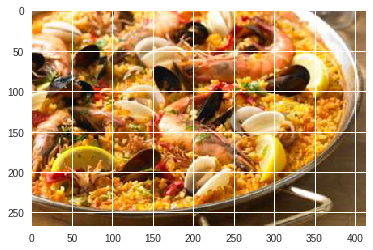

In [48]:
def predict_from_url(url, model):
    urllib.request.urlretrieve(url, "image.jpg")
    pil_image = Image.open("image.jpg")
    imshow(np.asarray(pil_image))
    torch_image = preprocess(pil_image).unsqueeze(0)
    output = model(torch_image)
    probs, idxs = output.topk(3)
    print(probs[0])
    print([labels[idx.item()] for idx in idxs[0]])

predict_from_url("https://images.tienda.com/is/image/LaTienda/mixed-seafood-paella?&wid=414&qlt=60", model)

In [0]:
https://images.tienda.com/is/image/LaTienda/mixed-seafood-paella?&wid=414&qlt=60